# Convolutional Neural Network that Classifies Facial Expressions
This is part of a pipeline that includes API deployment. The first model experiment and it's training is described here.

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [4]:
path = '/content/drive/MyDrive/Deep Learning/Facial Expressions/'

In [5]:
training = pd.read_csv('/content/drive/MyDrive/Deep Learning/Facial Expressions/train.csv')
training.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
full_set = pd.read_csv(path+'icml_face_data.csv')
full_set.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [7]:
type(training.iloc[0,1])

str

In [8]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Preprocessing
The image data is in a string, convert it to an array and reshape it to 48x48 pixels.

In [58]:
full_set.columns = [col.strip() for col in full_set.columns]

In [9]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

In [10]:
X_train, Y_train = prepare_data(training)
Y_train

array([0, 0, 2, ..., 4, 0, 4])

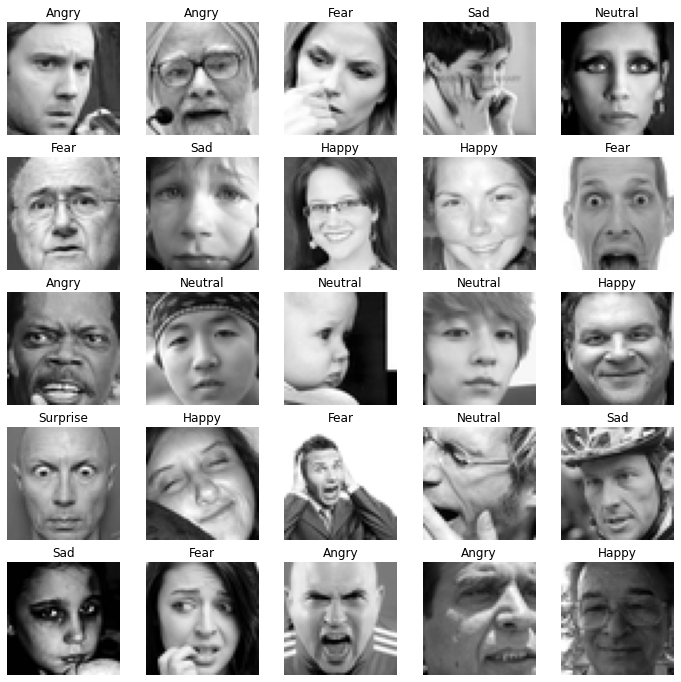

In [11]:
plt.figure(figsize=[12,12])
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i,:,:,0], cmap='binary_r')
    plt.title(emotions[Y_train[i]])
    plt.axis('off')

## Convolutional Neural Network

In [12]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [13]:
# One Hot Encoding
from keras.utils import to_categorical
Y_train_OH = to_categorical(Y_train)
Y_train_OH

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [25]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
          input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# 7 possible expressions
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 128)      

In [26]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

In [27]:
checkpoint_filepath = path + 'model_checkpoints/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [28]:
performance = model.fit(X_train, Y_train_OH, validation_split=0.2, batch_size=300, epochs=35, callbacks=[model_checkpoint_callback])

Epoch 1/35
77/77 [==============================] - 7s 77ms/step - loss: 2.4918 - accuracy: 0.2175 - val_loss: 2.7177 - val_accuracy: 0.2517
Epoch 2/35
77/77 [==============================] - 5s 68ms/step - loss: 1.7111 - accuracy: 0.3133 - val_loss: 3.5056 - val_accuracy: 0.1771
Epoch 3/35
77/77 [==============================] - 5s 68ms/step - loss: 1.5915 - accuracy: 0.3789 - val_loss: 3.3034 - val_accuracy: 0.1714
Epoch 4/35
77/77 [==============================] - 5s 68ms/step - loss: 1.5059 - accuracy: 0.4227 - val_loss: 2.5859 - val_accuracy: 0.2104
Epoch 5/35
77/77 [==============================] - 5s 68ms/step - loss: 1.4170 - accuracy: 0.4501 - val_loss: 4.2709 - val_accuracy: 0.1715
Epoch 6/35
77/77 [==============================] - 5s 68ms/step - loss: 1.3548 - accuracy: 0.4776 - val_loss: 2.6633 - val_accuracy: 0.1984
Epoch 7/35
77/77 [==============================] - 5s 69ms/step - loss: 1.2890 - accuracy: 0.5033 - val_loss: 3.2199 - val_accuracy: 0.2196
Epoch 8/35
77

In [47]:
performance.history

{'accuracy': [0.24861757457256317,
  0.32794880867004395,
  0.3890799880027771,
  0.42491400241851807,
  0.45243173837661743,
  0.481821745634079,
  0.5026342272758484,
  0.5203117728233337,
  0.542212724685669,
  0.557147204875946,
  0.5696433782577515,
  0.5818783640861511,
  0.6031262278556824,
  0.6179300546646118,
  0.6406148076057434,
  0.6512822508811951,
  0.6658684015274048,
  0.6850263476371765,
  0.6969565153121948,
  0.7141115665435791,
  0.7272173166275024,
  0.7412809729576111,
  0.7524709105491638,
  0.7653154730796814,
  0.7815126180648804,
  0.7886097431182861,
  0.8029346466064453,
  0.8121652603149414,
  0.8144729137420654,
  0.8253145813941956,
  0.8368528485298157,
  0.8411198854446411,
  0.8479992747306824,
  0.8584926128387451,
  0.8615404963493347],
 'loss': [2.1266367435455322,
  1.6850879192352295,
  1.5756311416625977,
  1.4875578880310059,
  1.414252758026123,
  1.3476382493972778,
  1.2976683378219604,
  1.257773995399475,
  1.208045244216919,
  1.162335038

[Text(0, 0.5, 'common ylabel'), Text(0.5, 0, 'common xlabel')]

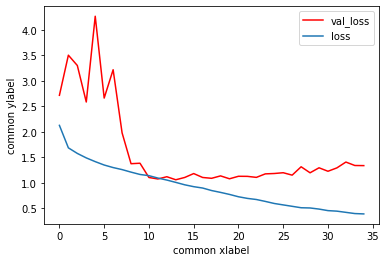

In [50]:
import seaborn as sns
ax = sns.lineplot(data=performance.history['val_loss'], label='val_loss', color='r')
sns.lineplot(data=performance.history['loss'], label='loss')
ax.set(xlabel='Epoch', ylabel='Value')

[Text(0, 0.5, 'Value'), Text(0.5, 0, 'Epoch')]

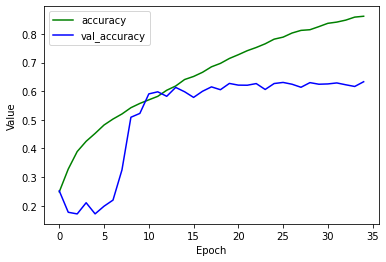

In [51]:
ax = sns.lineplot(data=performance.history['accuracy'], label='accuracy', color='g')
sns.lineplot(data=performance.history['val_accuracy'], label='val_accuracy', color='b')
ax.set(xlabel='Epoch', ylabel='Value')

## Saving **Model**

In [53]:
model.save(path + 'models/SimpleCNN.h5')

## Testing

In [63]:
testing = full_set[full_set['Usage'] != 'Training']
testing.head()

,emotion,Usage,pixels
28709,0,PublicTest,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,PublicTest,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,PublicTest,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,PublicTest,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,PublicTest,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [70]:
X_test, Y_test = prepare_data(testing)
print('Example of X_test: ' + str(X_test[0]))
print('Example of Y_test: ' + str(Y_test))

Example of X_test: [[[0.99607843]
  [0.99607843]
  [0.99607843]
  ...
  [0.0627451 ]
  [0.        ]
  [0.63137255]]

 [[0.99607843]
  [0.99607843]
  [0.99607843]
  ...
  [0.06666667]
  [0.        ]
  [0.47843137]]

 [[0.99607843]
  [0.99607843]
  [0.99607843]
  ...
  [0.10196078]
  [0.        ]
  [0.44705882]]

 ...

 [[0.25882353]
  [0.3372549 ]
  [0.38823529]
  ...
  [1.        ]
  [0.98823529]
  [0.99607843]]

 [[0.32941176]
  [0.36078431]
  [0.36078431]
  ...
  [0.9254902 ]
  [1.        ]
  [1.        ]]

 [[0.36470588]
  [0.35294118]
  [0.33333333]
  ...
  [0.16470588]
  [0.50588235]
  [0.70588235]]]
Example of Y_test: [0 1 4 ... 0 3 2]


In [72]:
test_prob = model.predict(X_test)

In [73]:
test_pred = np.argmax(test_prob, axis=1)
test_accuracy = np.mean(test_pred == Y_test)

In [74]:
test_accuracy

0.6287266648091391

### Wasn't too bad, needs more layers and better hyperparameter tuning
#### Confusion Matrix

In [75]:
from sklearn.metrics import confusion_matrix, classification_report

In [79]:
test_pred

array([0, 1, 0, ..., 4, 4, 2])

In [81]:
matrix = confusion_matrix(Y_test, test_pred)
pd.DataFrame(matrix, columns=emotions, index=emotions)

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral
Angry,540,5,99,51,148,31,84
Disgust,31,54,7,3,9,2,5
Fear,92,1,469,34,230,96,102
Happy,47,0,44,1449,85,44,105
Sad,153,0,142,79,695,18,160
Surprise,19,0,79,30,25,657,21
Neutral,110,1,73,102,267,31,649


## Next Up: Train using InceptionV3 / RNN

## MISC

In [18]:
# ! pip install -q kaggle

In [19]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [20]:
# ! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

In [21]:
# !cp train.csv '/content/drive/MyDrive/Deep Learning/Facial Expressions'

In [22]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7735678856551742588, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17294215884901390375
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]